In [1]:
# Imports

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter  
from sklearn.metrics import confusion_matrix
import calendar
from dateutil import relativedelta
import operator
import os
import random
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
import matplotlib.ticker as ticker
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: f'%.{len(str(x%1))-2}f' % x)
pd.set_option('display.max_colwidth', None)
%matplotlib inline

In [2]:
detail = pd.read_csv('BASE_CUSTS.csv',converters={'CIF_ID':str})
non_loan = pd.read_csv('ALLCUST_NONLOAN.csv',converters={'CIF_ID':str})
loan = pd.read_csv('ALLCUST_LOAN.csv',converters={'CIF_ID':str})
trans = pd.read_csv('ALLCUST_TRANSACTIONS.csv',converters={'CIF_ID':str})
eod = pd.read_csv('ALLCUSTEOD.csv',converters={'CIF_ID':str})
otg = pd.read_csv('ALLCUSTOTG.csv',converters={'CIF_ID':str})

In [3]:
trans.shape

(11758, 7)

In [4]:
dfs = [detail, non_loan, loan, trans, eod, otg ]

for i, df in enumerate(dfs, start=1):
    print(f"DataFrame {i} - Shape: {df.shape}, Unique IDs: {df['CIF_ID'].nunique()}")

DataFrame 1 - Shape: (1654, 22), Unique IDs: 1517
DataFrame 2 - Shape: (1503, 2), Unique IDs: 1503
DataFrame 3 - Shape: (1517, 2), Unique IDs: 1517
DataFrame 4 - Shape: (11758, 7), Unique IDs: 1514
DataFrame 5 - Shape: (1620, 3), Unique IDs: 366
DataFrame 6 - Shape: (1620, 6), Unique IDs: 139


In [5]:
detail.sample()

,CIF_ID,ACID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,CUSTOMERINCOME,SECTOR,SUBSECTOR,SECURED_FLG,PHYSICALADDRESS,MARITALSTATUS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,DISB_DATE_3WK,DISB_DATE,REP_PERD_MTHS,DPD_CNTR,FLOW_ID,FLOW_AMT,NO_OF_INSTALLMENTS
1409,0418841,IM21807888,51,0,BL03,0.0,ANY OTHER ACTIVITIES,ALL OTHER ACTIVITIES NOT UNDER ENTPR OR SCPS,N,BROWN APARTMENT L3,MARRIED,N,LAL06,HOUSING LOAN - GEN PUBLIC - LCY,11200000.0,18-SEP-23,28-AUG-23,120,0,EIDEM,183930.0,1


In [6]:
columns_to_drop = ['CUSTOMERINCOME', 'SECTOR', 'SUBSECTOR', 'SECURED_FLG', 
                   'PHYSICALADDRESS','MARITALSTATUS','DISB_DATE_3WK']
detail.drop(columns=columns_to_drop, inplace=True)

In [7]:
detail.sample()

,CIF_ID,ACID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,DISB_DATE,REP_PERD_MTHS,DPD_CNTR,FLOW_ID,FLOW_AMT,NO_OF_INSTALLMENTS
1294,0196345,IM21671980,49,4,BL03,N,LAL02,TERM LOAN- EMI- LCY,5830000.0,10-JUN-22,48,89,EIDEM,174750.0,1


In [8]:
# detail['FLOW_AMT'] == 0 are new loans and have not paid instalments on their loans yet 
detail = detail[~(detail['FLOW_AMT'] == 0)]


In [9]:
# Default on a loan has been described as 60 days past instalment payment date
detail['DEFAULT_STATUS'] = (detail['DPD_CNTR'] >= 60).astype(int)
default_status_counts = detail['DEFAULT_STATUS'].value_counts()

print("Number of 0's (DPD_CNTR < 60):", default_status_counts[0])
print("Number of 1's (DPD_CNTR >= 60):", default_status_counts[1])

Number of 0's (DPD_CNTR < 60): 1448
Number of 1's (DPD_CNTR >= 60): 206


## TRANSACTIONS

In [10]:
detail.drop('ACID', inplace=True,axis=1)
trans.drop('ACID',inplace=True,axis=1)

In [11]:
trans.sample()

,CIF_ID,TRAN_ID,PART_TRAN_TYPE,TRAN_CRNCY_CODE,TRAN_DATE,CONVERTED_AMOUNT
7843,0377083,S5991,D,KES,24-JAN-24,15.0


In [12]:
df_detail_trans = pd.merge(detail,trans,on='CIF_ID', how='left')

In [13]:
# df_detail_trans.drop(['SEGMENTATION_CLASS', 'SCHM_CODE'], axis=1, inplace=True)

In [14]:
detail.SEGMENTATION_CLASS.value_counts()

BL03    1090
BL05     564
Name: SEGMENTATION_CLASS, dtype: int64

In [15]:
schm_code_counts = detail['SCHM_CODE'].value_counts()


In [16]:
# import plotly.express as px
# fig = px.bar(schm_code_counts, x=schm_code_counts.index, y=schm_code_counts.values, 
#              labels={'SCHM_CODE': 'Scheme Code', 'count': 'Count'},
#              title='Value Counts of Scheme Codes')

# fig.show()

In [17]:
schm_code_counts.values

array([569, 322, 317, 207, 170,  30,  22,   9,   5,   3])

In [18]:
debit_trans = trans[trans['PART_TRAN_TYPE'] == 'D']
credit_trans = trans[trans['PART_TRAN_TYPE'] == 'C']


In [19]:
debit_trans.shape

(3715, 6)

In [20]:
credit_trans['UNIQUE_ID'] = [x + '_' + y for x,y in zip(credit_trans['CIF_ID'],credit_trans['TRAN_ID'])]
debit_trans['UNIQUE_ID'] = [x + '_' + y for x,y in zip(debit_trans['CIF_ID'],debit_trans['TRAN_ID'])]
credit_trans = credit_trans[~credit_trans['UNIQUE_ID'].isin(debit_trans['UNIQUE_ID'])]

In [21]:
credit_trans.drop('UNIQUE_ID',inplace=True,axis=1)


In [22]:
grouped_debits = debit_trans.groupby(['CIF_ID']).size().reset_index(name='DEBIT_COUNT')
grouped_credits = credit_trans.groupby(['CIF_ID']).size().reset_index(name='CREDIT_COUNT')

In [23]:
grouped_debits.shape

(348, 2)

In [24]:
grouped_debits.sample()

,CIF_ID,DEBIT_COUNT
204,0380966,1


In [25]:
merged_df = grouped_debits.merge(grouped_credits, on=['CIF_ID'], how='left').fillna(0)

In [26]:
merged_df.shape

(348, 3)

In [27]:
merged_df.sample()

,CIF_ID,DEBIT_COUNT,CREDIT_COUNT
234,0383601,1,2.0


In [28]:
pd.set_option('display.float_format', '{:.1f}'.format)
merged_df['DEBIT_CREDIT_COUNT_RATIO_3weeks'] = merged_df['DEBIT_COUNT'] / merged_df['CREDIT_COUNT'].replace(0, 1)


In [29]:
merged_df.sample()

,CIF_ID,DEBIT_COUNT,CREDIT_COUNT,DEBIT_CREDIT_COUNT_RATIO_3weeks
174,0377892,1,1.0,1.0


In [30]:
summary_df = merged_df.groupby('CIF_ID')['DEBIT_CREDIT_COUNT_RATIO_3weeks'].agg(['mean', 'median']).reset_index()
summary_df.rename(columns={'mean': 'AVG_DEBIT_CREDIT_COUNT_RATIO', 'median': 'MEDIAN_DEBIT_CREDIT_COUNT_RATIO'}, inplace=True)


In [31]:
summary_df.sample()

,CIF_ID,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO
314,0397020,3.0,3.0


In [32]:
summary_df.shape

(348, 3)

In [33]:
trans_cr = trans[trans['PART_TRAN_TYPE'] == 'C']
trans_dr = trans[trans['PART_TRAN_TYPE'] == 'D']

In [34]:
trans_cr['UNIQUE_ID'] = [x + '_' + y for x,y in zip(trans_cr['CIF_ID'],trans_cr['TRAN_ID'])]
trans_dr['UNIQUE_ID'] = [x + '_' + y for x,y in zip(trans_dr['CIF_ID'],trans_dr['TRAN_ID'])]
trans_cr = trans_cr[~trans_cr['UNIQUE_ID'].isin(trans_dr['UNIQUE_ID'])]

In [35]:
trans_cr.drop('UNIQUE_ID',inplace=True,axis=1)
trans_dr.drop('UNIQUE_ID',inplace=True,axis=1)

In [36]:
trans_dr.shape

(3715, 6)

In [37]:
detail.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,DISB_DATE,REP_PERD_MTHS,DPD_CNTR,FLOW_ID,FLOW_AMT,NO_OF_INSTALLMENTS,DEFAULT_STATUS
963,0416061,37,0,BL03,N,LAL30,STOCK FINANCE LOAN - LCY,600.0,23-NOV-23,0,62,PRDEM,600.0,1,1


In [38]:
trans_cr = pd.merge(trans_cr,detail[['CIF_ID']],
                   how='left',on='CIF_ID')
trans_dr = pd.merge(trans_dr,detail[['CIF_ID']],
                   how='left',on='CIF_ID')

## CREDIT AGGREGATIONS

In [39]:
trans_cr.shape

(4789, 6)

In [40]:
grouped_cr_weekly = trans_cr.groupby(['CIF_ID']).agg({
    'CONVERTED_AMOUNT': ['sum', 'count','median','mean','min','max']
}).reset_index()
grouped_cr_weekly.columns = ['_'.join(col).strip() for col in grouped_cr_weekly.columns.values]
grouped_cr_weekly.rename(columns={'CIF_ID_': 'CIF_ID','CONVERTED_AMOUNT_sum':'Credit_sum' ,
                                 'CONVERTED_AMOUNT_count':'Credit_count', 'CONVERTED_AMOUNT_median':'Credit_median',
                                 'CONVERTED_AMOUNT_mean':'Credit_mean', 'CONVERTED_AMOUNT_min': 'min_cred_amt_3_weeks',
                            'CONVERTED_AMOUNT_max': 'max_cred_amt_3_weeks'}, inplace=True)

grouped_cr_weekly.sample(4)

,CIF_ID,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks
241,0390227,97766.0,5,2000.0,19553.2,1000.0,74338.0
223,0387131,126782.0,1,126782.0,126782.0,126782.0,126782.0
131,0376459,458550.0,8,6000.0,57318.8,6000.0,410550.0
146,0380064,11312.0,2,5656.0,5656.0,5656.0,5656.0


In [41]:
grouped_cr_weekly.shape

(313, 7)

In [42]:
grouped_cr_weekly.drop_duplicates(keep='first',inplace=True)

In [43]:
grouped_cr_weekly.shape

(313, 7)

## DEBIT AGGREGATIONS

In [44]:
grouped_dr_weekly = trans_dr.groupby(['CIF_ID']).agg({
    'CONVERTED_AMOUNT': ['sum', 'count', 'mean','median','min','max']
}).reset_index()
grouped_dr_weekly.columns = ['_'.join(col).strip() for col in grouped_dr_weekly.columns.values]
grouped_dr_weekly.rename(columns={'CIF_ID_': 'CIF_ID','CONVERTED_AMOUNT_sum':'Debit_sum', 
                                 'CONVERTED_AMOUNT_count': 'Debit_count', 'CONVERTED_AMOUNT_mean':'Debit_mean',
                                 'CONVERTED_AMOUNT_median':'Debit_median','CONVERTED_AMOUNT_min': 'min_debit_amt_3_weeks',
                            'CONVERTED_AMOUNT_max': 'max_debit_amt_3_weeks'}, inplace=True)

grouped_dr_weekly.sample()

,CIF_ID,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks
235,0383679,17420.7,18,967.8,80.0,1.0,7000.0


In [45]:
grouped_dr_weekly.shape

(348, 7)

In [46]:
grouped_dr_weekly.drop_duplicates(keep='first',inplace=True)

In [47]:
grouped_dr_weekly.shape

(348, 7)

## End of Day Balances(EOD)

In [48]:
eod.columns

Index(['CIF_ID', 'EOD_DATE', 'TRAN_DATE_BAL'], dtype='object')

In [49]:
eod.sample()

,CIF_ID,EOD_DATE,TRAN_DATE_BAL
417,0395048,14-JAN-24,21007.4


In [50]:
eod['EOD_DATE'] = pd.to_datetime(eod['EOD_DATE'])

# eod['TRAN_WEEK'] = eod['EOD_DATE'].dt.strftime('%U')



In [51]:
grouped_eod_weekly = eod.groupby(['CIF_ID']).agg({'TRAN_DATE_BAL': ['mean', 'median']}).reset_index()
grouped_eod_weekly.columns = ['_'.join(col).strip() for col in grouped_eod_weekly.columns.values]
grouped_eod_weekly.rename(columns={'CIF_ID_': 'CIF_ID'}, inplace=True)

grouped_eod_mean_median = grouped_eod_weekly.groupby('CIF_ID').agg({
    'TRAN_DATE_BAL_mean': ['mean', 'median']
}).reset_index()
grouped_eod_mean_median.columns = ['_'.join(col).strip() for col in grouped_eod_mean_median.columns.values]

grouped_eod_mean_median.rename(columns={
    'CIF_ID_': 'CIF_ID',
    'TRAN_DATE_BAL_mean_mean': 'avg_eod_bal_3_weeks',
    'TRAN_DATE_BAL_mean_median': 'median_eod_bal_3_weeks'
}, inplace=True)

In [52]:
grouped_eod_mean_median.shape

(366, 3)

In [53]:
grouped_eod_mean_median.sample()

,CIF_ID,avg_eod_bal_3_weeks,median_eod_bal_3_weeks
83,0163235,3000.0,3000.0


## Loan and Non Loan 

In [54]:
loan = loan.rename(columns={'LOAN_ACCT_PRIOR': 'no_of_loan_accounts'})

In [55]:
loan.columns

Index(['CIF_ID', 'no_of_loan_accounts'], dtype='object')

In [56]:
loan.sample()

,CIF_ID,no_of_loan_accounts
330,0128790,1


In [57]:
loan.isna().sum()

CIF_ID                 0
no_of_loan_accounts    0
dtype: int64

In [58]:
non_loan = non_loan.rename(columns={'NO_OF_NON_LOAN_ACCOUNTS': 'no_of_non_loan_accounts'})

In [59]:
loans_df = pd.merge(loan,non_loan,how='left', on='CIF_ID')

In [60]:
loans_df.fillna(0, inplace=True)

In [61]:
loans_df.drop_duplicates(keep='first', inplace=True)

In [62]:
loans_df.columns

Index(['CIF_ID', 'no_of_loan_accounts', 'no_of_non_loan_accounts'], dtype='object')

## OTG

In [63]:
otg.sample()

,CIF_ID,TRAN_ID,DISB_DATE,TRAN_DATE,TRAN_MONTH,TRAN_AMOUNT
836,0393247,S241053,14-JUN-23,30-JAN-24,JAN-24,1200


In [64]:
otg.shape

(1620, 6)

In [65]:
otg_unique = otg.groupby(['CIF_ID']).agg({
    'TRAN_AMOUNT': ['sum', 'count', 'mean','median','min','max']
}).reset_index()
otg_unique.columns = ['_'.join(col).strip() for col in otg_unique.columns.values]
otg_unique.rename(columns={'CIF_ID_': 'CIF_ID','TRAN_AMOUNT_sum':'OTG_trans_sum', 
                                 'TRAN_AMOUNT_count': 'OTG_trans_count', 'TRAN_AMOUNT_mean':'OTG_trans_mean',
                                 'TRAN_AMOUNT_median':'OTG_trans_median','TRAN_AMOUNT_min': 'min_otgcred_amt',
                            'TRAN_AMOUNT_max': 'max_otgcred_amt'}, inplace=True)


In [66]:
otg_unique.sample()

,CIF_ID,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt
101,0382407,26650,10,2665.0,2400.0,300,6000


In [67]:
otg_unique.shape

(139, 7)

In [68]:
otg_unique.drop_duplicates(keep='first',inplace=True)

In [69]:
otg_unique.shape

(139, 7)

## Merging files 

In [70]:
final_df_0 = pd.merge(grouped_dr_weekly,grouped_cr_weekly,how='left', on = 'CIF_ID')

In [71]:
final_df_0.columns

Index(['CIF_ID', 'Debit_sum', 'Debit_count', 'Debit_mean', 'Debit_median',
       'min_debit_amt_3_weeks', 'max_debit_amt_3_weeks', 'Credit_sum',
       'Credit_count', 'Credit_median', 'Credit_mean', 'min_cred_amt_3_weeks',
       'max_cred_amt_3_weeks'],
      dtype='object')

In [72]:
len(final_df_0)

348

In [73]:
columns_to_drop = ['DISB_DATE']
detail = detail.drop(columns=columns_to_drop)

In [74]:
final_df_1 = pd.merge(detail,otg_unique,how='left', on = 'CIF_ID')

In [75]:
final_df_1 = pd.merge(final_df_1,final_df_0,how='left', on = 'CIF_ID')

In [76]:
final_df_2 = pd.merge(final_df_1, summary_df, how='left', on = 'CIF_ID')

In [77]:
final_df_3 = pd.merge(final_df_2, loans_df, how='left', on = 'CIF_ID')

In [78]:
final_df_3 = pd.merge(final_df_3, grouped_eod_mean_median, how='left', on = 'CIF_ID')

In [79]:
merged_df = final_df_3.copy()

In [80]:
merged_df.drop_duplicates(keep='first', inplace=True)

In [81]:
merged_df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,DPD_CNTR,FLOW_ID,FLOW_AMT,NO_OF_INSTALLMENTS,DEFAULT_STATUS,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,median_eod_bal_3_weeks
1479,0123759,51,8,BL05,N,LAL06,HOUSING LOAN - GEN PUBLIC - LCY,116043180.0,180,0,EIDEM,7550740.0,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,NaN,NaN


In [82]:
merged_df.shape

(1654, 38)

# EDA

In [83]:
merged_df['DEFAULT_STATUS'] = merged_df['DEFAULT_STATUS'].map({0: 'performing', 1: 'non_performing'})

In [84]:
merged_df['DEFAULT_STATUS'].value_counts()

performing        1448
non_performing     206
Name: DEFAULT_STATUS, dtype: int64

In [85]:
def age_group(age):
    if age <= 17:  
        return "Minor"
    elif age <= 27: 
        return "Young Adult"
    elif age <= 34:  
        return "Adult"
    elif age <= 45: 
        return "Mid-aged"
    
    elif age <= 64:  
        return "Senior"
    else:  
        return "Elderly"

merged_df['AGE_GROUP'] = merged_df['CUST_AGE'].apply(lambda x: age_group(x))

In [86]:
feature2_cols = ["OTG_TRANSACTING"]

In [87]:
age_otg_analysis = merged_df.groupby(['AGE_GROUP', 'OTG_TRANSACTING'])['CIF_ID'].count().unstack()

print(age_otg_analysis)

OTG_TRANSACTING    N    Y
AGE_GROUP                
Adult             67  278
Elderly           56   15
Mid-aged         236  346
Senior           301  246
Young Adult       38   71


In [88]:
columns_of_interest = ['min_cred_amt_3_weeks', 'max_cred_amt_3_weeks', 'avg_cred_amt_3_weeks',
                       'median_cred_amt_3_weeks', 'avg_weekly_cred_count_3_weeks',
                       'avg_eod_bal_3_weeks', 'median_eod_bal_3_weeks', 'min_debit_amt_3_weeks',
                       'max_debit_amt_3_weeks', 'avg_debit_amt_3_weeks', 'median_debit_amt_3_weeks',
                       'avg_weekly_debit_count_3_weeks','AVG_WEEKLY_DEBIT_CREDIT_COUNT_RATIO',
                       'MEDIAN_WEEKLY_DEBIT_CREDIT_COUNT_RATIO']


### CREDIT TO DEBIT RATIO

In [89]:
merged_df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_CODE,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,DPD_CNTR,FLOW_ID,FLOW_AMT,NO_OF_INSTALLMENTS,DEFAULT_STATUS,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,median_eod_bal_3_weeks,AGE_GROUP
1632,0428039,46,0,BL03,N,LAL27,WORK PLACE BANKING FACILITY,960000.0,72,0,EIDEM,20825.0,1,performing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,NaN,NaN,Senior


In [90]:
merged_df['avg_credit_to_debit_amt_ratio_3_weeks'] = merged_df['Credit_mean'] / merged_df['Debit_mean']
merged_df['median_credit_to_debit_ratio_3_weeks'] = merged_df['Credit_median'] / merged_df['Debit_median']

In [91]:
status_mapping = {'performing': 0, 'non_performing': 1}

merged_df['DEFAULT_STATUS_ENCODED'] = merged_df['DEFAULT_STATUS'].map(status_mapping)


In [92]:
merged_df['DEFAULT_STATUS_ENCODED'].value_counts()

0    1448
1     206
Name: DEFAULT_STATUS_ENCODED, dtype: int64

In [93]:
## Helper Functions

def transformDate(df, datecol): 

    """
    function to transform the datefield into a datetime object, and generate associated date elements such as day,week,month,year etc.
    Args: Dataframe, datefield
    returns: Dataframe
    """
    df[datecol] = pd.to_datetime(df[datecol])
    df['Day'] = df[datecol].dt.day_name()
    df['Week'] = df[datecol].dt.week
    df['MonthName'] = df[datecol].dt.month_name()
    df['Year'] = df[datecol].dt.year

    return df

## Distribution plots for categorical variables
def univ_analysis(categ_cols, data):
    """
    Function to generate countplot of categorical variables.
    Args: categ_cols (a list of all the categorical fields), & the corresponding dataframe
    returns: countplots of all the categorical fields passed in.
    """
    for i in categ_cols:
        plt.figure(figsize=(12,6))
        if data[i].nunique()>10:
      # data[i].value_counts()[:10].plot(kind = 'bar')
            ax = (data[i].value_counts(ascending=False)[:10]/data[i].notnull().sum()*100).plot(kind='bar')
            ax.set_yticks(np.arange(0,110,10))
            ax2 = ax.twinx()
            ax2.set_yticks(np.arange(0,110,10)*data[i].notnull().sum()/100)

            for p in ax.patches:
                ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

            plt.title(i+'_Distribution')
            plt.show()
            plt.savefig(i+'_Distribution.png')

        else:
            ncount = data[i].notnull().sum()
            ax = sns.countplot(x=i, data=data)
            plt.xticks(rotation=90)
            plt.title(i + '_Distribution')

            # Make twin axis
            ax2=ax.twinx()

            # Switch so count axis is on right, frequency on left
            ax2.yaxis.tick_left()
            ax.yaxis.tick_right()

            # Also switch the labels over
            ax.yaxis.set_label_position('right')
            ax2.yaxis.set_label_position('left')

            for p in ax.patches:
                x=p.get_bbox().get_points()[:,0]
                y=p.get_bbox().get_points()[1,1]
                ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                        ha='center', va='bottom') # set the alignment of the text

            # Use a LinearLocator to ensure the correct number of ticks
            ax.yaxis.set_major_locator(ticker.LinearLocator(11))

            # Fix the frequency range to 0-100
            ax2.set_ylim(0,100)
            ax.set_ylim(0,ncount)

            # And use a MultipleLocator to ensure a tick spacing of 10
            ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

            # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
            ax2.grid(None)
            plt.show()

            # fig = plt.figure()
            # return fig


## Continuous Variables Distribution Plots

def hist_plot(df, vals):
    """
      Function to generate density plot.
      Args: dataframe, & variable (continuous)
      returns: density plot.
    """
    # sns.set(style="whitegrid", palette='Blues_r')
    sns.histplot(df[vals])
    plt.title('Histogram of ' + vals)
    plt.show()

In [94]:
merged_df['CUST_AGE'].max(), merged_df['CUST_AGE'].min()

(124, 21)

In [95]:
merged_df['cust_age_bin_tmp'] = pd.cut(merged_df['CUST_AGE'], bins=6)
bin_edges = merged_df['cust_age_bin_tmp'].cat.categories
labels = [f"{int(bin.left) + 1}-{int(bin.right)}" for bin in bin_edges]
merged_df['cust_age_bin'] = pd.cut(merged_df['CUST_AGE'], bins=6, labels=labels)
merged_df.drop('cust_age_bin_tmp', axis=1, inplace=True)

In [96]:
merged_df['cust_age_bin'].unique()

['56-72', '39-55', '21-38', '73-89', '107-124']
Categories (6, object): ['21-38' < '39-55' < '56-72' < '73-89' < '90-106' < '107-124']

In [97]:
categ_cols = ['first_otg_trans_bin', 'number_of_inactive_weeks_otg_bin',
              'MARITALSTATUS','OTG_TRANSACTING', 'AGE_GROUP','cust_age_bin','age_with_bank_bin']

# Modelling

In [98]:
df = merged_df.copy()

In [99]:
df.columns

Index(['CIF_ID', 'CUST_AGE', 'AGE_WITH_BANK', 'SEGMENTATION_CLASS',
       'OTG_TRANSACTING', 'SCHM_CODE', 'SCHM_DESC', 'DIS_AMT', 'REP_PERD_MTHS',
       'DPD_CNTR', 'FLOW_ID', 'FLOW_AMT', 'NO_OF_INSTALLMENTS',
       'DEFAULT_STATUS', 'OTG_trans_sum', 'OTG_trans_count', 'OTG_trans_mean',
       'OTG_trans_median', 'min_otgcred_amt', 'max_otgcred_amt', 'Debit_sum',
       'Debit_count', 'Debit_mean', 'Debit_median', 'min_debit_amt_3_weeks',
       'max_debit_amt_3_weeks', 'Credit_sum', 'Credit_count', 'Credit_median',
       'Credit_mean', 'min_cred_amt_3_weeks', 'max_cred_amt_3_weeks',
       'AVG_DEBIT_CREDIT_COUNT_RATIO', 'MEDIAN_DEBIT_CREDIT_COUNT_RATIO',
       'no_of_loan_accounts', 'no_of_non_loan_accounts', 'avg_eod_bal_3_weeks',
       'median_eod_bal_3_weeks', 'AGE_GROUP',
       'avg_credit_to_debit_amt_ratio_3_weeks',
       'median_credit_to_debit_ratio_3_weeks', 'DEFAULT_STATUS_ENCODED',
       'cust_age_bin'],
      dtype='object')

In [100]:
df.shape

(1654, 43)

In [101]:
df = df.drop_duplicates(subset='CIF_ID',keep='first')

In [102]:
df.OTG_TRANSACTING.isna().sum()

0

In [103]:
df.drop(columns = ['DPD_CNTR','SCHM_CODE','DEFAULT_STATUS',
                   'AGE_GROUP','cust_age_bin'], inplace =True)

In [104]:
df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,FLOW_ID,FLOW_AMT,NO_OF_INSTALLMENTS,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,median_eod_bal_3_weeks,avg_credit_to_debit_amt_ratio_3_weeks,median_credit_to_debit_ratio_3_weeks,DEFAULT_STATUS_ENCODED
1424,0441121,37,0,BL03,Y,WORK PLACE BANKING FACILITY,550000.0,60,EIDEM,13669.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,NaN,NaN,NaN,NaN,0


In [105]:
otg_columns = otg_unique.columns.to_list()

In [106]:
df[otg_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1517 entries, 0 to 1653
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CIF_ID            1517 non-null   object 
 1   OTG_trans_sum     139 non-null    float64
 2   OTG_trans_count   139 non-null    float64
 3   OTG_trans_mean    139 non-null    float64
 4   OTG_trans_median  139 non-null    float64
 5   min_otgcred_amt   139 non-null    float64
 6   max_otgcred_amt   139 non-null    float64
dtypes: float64(6), object(1)
memory usage: 94.8+ KB


In [107]:
df[otg_columns] = df[otg_columns].fillna(0)


In [108]:
def map_schm(x):
    key_list = ['TERM LOAN- EMI- LCY', 'SHORT TERM LOAN - LCY',
       'WORK PLACE BANKING FACILITY', 'HOUSING LOAN - GEN PUBLIC - LCY',
       'HOUSING LOAN - GEN PUBLIC - FCY', 'STOCK FINANCE LOAN - LCY',
       'ASSET FINANCE PUBLIC- EMI - LCY',
       'GOVERNMENT SCHEME WORK PLACE BANKING FACILITY',
       'HIRE PURCHASE -GROUP COMPANIES - LCY', 'TERM LOAN- NON EMI - FCY']
    value_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

    if x in key_list:
        value_index = key_list.index(x)
        return value_list[value_index]
    else:
        return 12 

df['schm_code_encoded'] = df['SCHM_DESC'].map(lambda x: map_schm(x))


In [109]:
df.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,SEGMENTATION_CLASS,OTG_TRANSACTING,SCHM_DESC,DIS_AMT,REP_PERD_MTHS,FLOW_ID,FLOW_AMT,NO_OF_INSTALLMENTS,OTG_trans_sum,OTG_trans_count,OTG_trans_mean,OTG_trans_median,min_otgcred_amt,max_otgcred_amt,Debit_sum,Debit_count,Debit_mean,Debit_median,min_debit_amt_3_weeks,max_debit_amt_3_weeks,Credit_sum,Credit_count,Credit_median,Credit_mean,min_cred_amt_3_weeks,max_cred_amt_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,MEDIAN_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,median_eod_bal_3_weeks,avg_credit_to_debit_amt_ratio_3_weeks,median_credit_to_debit_ratio_3_weeks,DEFAULT_STATUS_ENCODED,schm_code_encoded
1142,0386875,26,0,BL03,Y,WORK PLACE BANKING FACILITY,550000.0,48,EIDEM,30060.0,2,0.0,0.0,0.0,0.0,0.0,0.0,254.7,2.0,127.4,127.4,38.0,216.7,15030.0,1.0,15030.0,15030.0,15030.0,15030.0,2.0,2.0,1,2.0,7406.6,7406.6,118.0,118.0,0,3


In [110]:
merged_df.SCHM_DESC.value_counts()

WORK PLACE BANKING FACILITY                      569
TERM LOAN- EMI- LCY                              322
HOUSING LOAN - GEN PUBLIC - LCY                  317
GOVERNMENT SCHEME WORK PLACE BANKING FACILITY    207
STOCK FINANCE LOAN - LCY                         170
SHORT TERM LOAN - LCY                             30
HOUSING LOAN - GEN PUBLIC - FCY                   22
ASSET FINANCE PUBLIC- EMI - LCY                    9
TERM LOAN- NON EMI - FCY                           5
HIRE PURCHASE -GROUP COMPANIES - LCY               3
Name: SCHM_DESC, dtype: int64

In [111]:
del df['SCHM_DESC']

In [112]:
mapping = {'BL05': 1, 'BL03': 0}

df['SEGMENTATION_CLASS_ENCODED'] = df['SEGMENTATION_CLASS'].map(mapping)


In [113]:
del df['SEGMENTATION_CLASS']

In [114]:
mapping = {'N': 0, 'Y': 1}

df['OTG_TRANSACTING_ENCODED'] = df['OTG_TRANSACTING'].map(mapping)


In [115]:
del df['OTG_TRANSACTING']

In [116]:
df = df.fillna(0)

In [117]:
df_correct = df.copy()

In [118]:
df_correct.shape

(1517, 38)

In [119]:
df_correct.CIF_ID.nunique()

1517

In [120]:
df_correct.columns

Index(['CIF_ID', 'CUST_AGE', 'AGE_WITH_BANK', 'DIS_AMT', 'REP_PERD_MTHS',
       'FLOW_ID', 'FLOW_AMT', 'NO_OF_INSTALLMENTS', 'OTG_trans_sum',
       'OTG_trans_count', 'OTG_trans_mean', 'OTG_trans_median',
       'min_otgcred_amt', 'max_otgcred_amt', 'Debit_sum', 'Debit_count',
       'Debit_mean', 'Debit_median', 'min_debit_amt_3_weeks',
       'max_debit_amt_3_weeks', 'Credit_sum', 'Credit_count', 'Credit_median',
       'Credit_mean', 'min_cred_amt_3_weeks', 'max_cred_amt_3_weeks',
       'AVG_DEBIT_CREDIT_COUNT_RATIO', 'MEDIAN_DEBIT_CREDIT_COUNT_RATIO',
       'no_of_loan_accounts', 'no_of_non_loan_accounts', 'avg_eod_bal_3_weeks',
       'median_eod_bal_3_weeks', 'avg_credit_to_debit_amt_ratio_3_weeks',
       'median_credit_to_debit_ratio_3_weeks', 'DEFAULT_STATUS_ENCODED',
       'schm_code_encoded', 'SEGMENTATION_CLASS_ENCODED',
       'OTG_TRANSACTING_ENCODED'],
      dtype='object')

In [121]:
df_correct.drop(columns=['Debit_mean', 'Credit_mean', 'Debit_median','Credit_median',
                         'Debit_count', 'Credit_count','max_cred_amt_3_weeks', 'min_cred_amt_3_weeks', 'Credit_sum'
                         , 'Debit_sum','min_debit_amt_3_weeks', 'max_debit_amt_3_weeks','MEDIAN_DEBIT_CREDIT_COUNT_RATIO'
                        ,'median_eod_bal_3_weeks','max_debit_amt_3_weeks',
                        'OTG_trans_median','median_eod_bal_3_weeks','min_otgcred_amt','median_credit_to_debit_ratio_3_weeks',
                         'OTG_trans_sum', 'max_otgcred_amt'],inplace = True)


In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

X = df_correct.drop('DEFAULT_STATUS_ENCODED', axis=1)
y = df_correct['DEFAULT_STATUS_ENCODED']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [123]:
# top_features = sorted_feature_importance.head(20).index

# correlation_matrix = df_correct[top_features].corr()


# plt.figure(figsize=(18, 14))
# sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
# plt.title("Correlation Matrix of Top Features")
# plt.show()


In [124]:
df_correct.sample()

,CIF_ID,CUST_AGE,AGE_WITH_BANK,DIS_AMT,REP_PERD_MTHS,FLOW_ID,FLOW_AMT,NO_OF_INSTALLMENTS,OTG_trans_count,OTG_trans_mean,AVG_DEBIT_CREDIT_COUNT_RATIO,no_of_loan_accounts,no_of_non_loan_accounts,avg_eod_bal_3_weeks,avg_credit_to_debit_amt_ratio_3_weeks,DEFAULT_STATUS_ENCODED,schm_code_encoded,SEGMENTATION_CLASS_ENCODED,OTG_TRANSACTING_ENCODED
1239,0065670,49,11,6500000.0,60,EIDEM,158213.0,1,0.0,0.0,0.0,6,3.0,0.0,0.0,0,1,1,1


In [125]:
trans.sample()

,CIF_ID,TRAN_ID,PART_TRAN_TYPE,TRAN_CRNCY_CODE,TRAN_DATE,CONVERTED_AMOUNT
2581,0084469,S38423,C,KES,19-JAN-24,1070.0


In [126]:
# upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
# top_correlations = upper_triangle.unstack().dropna().abs().sort_values(ascending=False).head(10)
# print(top_correlations)


In [127]:
numerical_columns = df_correct.select_dtypes(include=['int64', 'float64', 'uint64']).columns
numerical_columns = numerical_columns.drop('DEFAULT_STATUS_ENCODED')


In [128]:
df_correct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1517 entries, 0 to 1653
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CIF_ID                                 1517 non-null   object 
 1   CUST_AGE                               1517 non-null   int64  
 2   AGE_WITH_BANK                          1517 non-null   int64  
 3   DIS_AMT                                1517 non-null   float64
 4   REP_PERD_MTHS                          1517 non-null   int64  
 5   FLOW_ID                                1517 non-null   object 
 6   FLOW_AMT                               1517 non-null   float64
 7   NO_OF_INSTALLMENTS                     1517 non-null   int64  
 8   OTG_trans_count                        1517 non-null   float64
 9   OTG_trans_mean                         1517 non-null   float64
 10  AVG_DEBIT_CREDIT_COUNT_RATIO           1517 non-null   float64
 11  no_o

In [129]:
y_true = df_correct['DEFAULT_STATUS_ENCODED']

In [130]:
df2 = df_correct.copy()

In [136]:
import pickle

with open('hyperperameterw_01.sav', 'rb') as file:
    model = pickle.load(file)

In [132]:
y_true = df2['DEFAULT_STATUS_ENCODED']

In [133]:
cif_ids = df2['CIF_ID']

In [140]:

selected_columns = ['REP_PERD_MTHS', 'DIS_AMT', 'avg_credit_to_debit_amt_ratio_3_weeks',
       'schm_code_encoded', 'avg_eod_bal_3_weeks',
       'AVG_DEBIT_CREDIT_COUNT_RATIO', 'FLOW_AMT', 'CUST_AGE',
       'no_of_loan_accounts']
df2.fillna(0, inplace=True)

X_selected = df2[selected_columns]

predictions = model.predict(X_selected)
probabilities = model.predict_proba(X_selected)

In [141]:
results = pd.DataFrame({
    'CIF_ID': cif_ids,
    'Predictions': predictions,
    'Probabilities': probabilities[:, 1],  
    #'y_true': y_true 
})

In [147]:
conf_matrix = confusion_matrix(y_true, predictions)


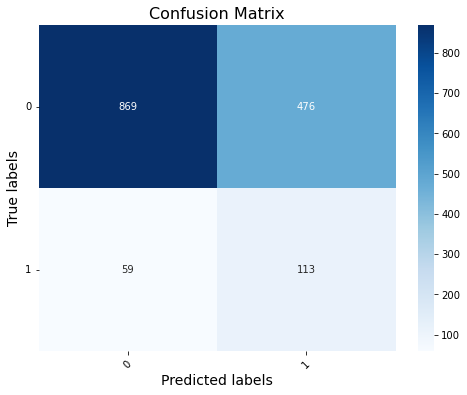

In [148]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

label_font = {'size':'14'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Confusion Matrix', fontdict={'size':'16'})
tick_marks = np.arange(len(np.unique(y_true))) + 0.5
plt.xticks(tick_marks, np.unique(y_true), rotation=45)
plt.yticks(tick_marks, np.unique(y_true), rotation=0)

plt.show()


In [149]:
test_df  = df2[['CIF_ID','REP_PERD_MTHS', 'DIS_AMT', 'avg_credit_to_debit_amt_ratio_3_weeks',
       'schm_code_encoded', 'avg_eod_bal_3_weeks',
       'AVG_DEBIT_CREDIT_COUNT_RATIO', 'FLOW_AMT', 'CUST_AGE',
       'no_of_loan_accounts','DEFAULT_STATUS_ENCODED']]

In [150]:
result_df = test_df.merge(results, how='left', on='CIF_ID')

In [151]:
result_df.sample()

,CIF_ID,REP_PERD_MTHS,DIS_AMT,avg_credit_to_debit_amt_ratio_3_weeks,schm_code_encoded,avg_eod_bal_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,FLOW_AMT,CUST_AGE,no_of_loan_accounts,DEFAULT_STATUS_ENCODED,Predictions,Probabilities
1213,0373010,0,850000.0,0.0,6,0.0,0.0,850000.0,43,18,0,0,0.4


In [155]:
result_df.to_csv('ALLCUSTLOANS_scores.csv', index = False)

In [153]:
hypthesisdf = result_df.copy()

In [154]:
hypthesisdf[hypthesisdf['Predictions'] == 1].describe()

,REP_PERD_MTHS,DIS_AMT,avg_credit_to_debit_amt_ratio_3_weeks,schm_code_encoded,avg_eod_bal_3_weeks,AVG_DEBIT_CREDIT_COUNT_RATIO,FLOW_AMT,CUST_AGE,no_of_loan_accounts,DEFAULT_STATUS_ENCODED,Predictions,Probabilities
count,589.0,589.0,589.0,589.0,589.0,589.0,589.0,589.0,589.0,589.0,589.0,589.0
mean,95.9,9815993.0,0.2,3.3,24357.7,0.2,417599.1,45.4,1.6,0.2,1.0,0.6
std,65.9,15313199.2,0.7,1.4,242868.0,1.0,2332675.4,11.3,1.1,0.4,0.0,0.1
min,0.0,100.0,0.0,1.0,-1758488.8,0.0,38.0,22.0,1.0,0.0,1.0,0.5
25%,48.0,1925149.0,0.0,3.0,0.0,0.0,77656.0,38.0,1.0,0.0,1.0,0.6
50%,72.0,5916993.8,0.0,4.0,0.0,0.0,145062.0,44.0,1.0,0.0,1.0,0.7
75%,156.0,11500000.0,0.0,4.0,0.0,0.0,256715.0,52.0,2.0,0.0,1.0,0.7
max,240.0,150000000.0,12.0,6.0,3055067.1,19.0,50075041.7,124.0,6.0,1.0,1.0,0.9


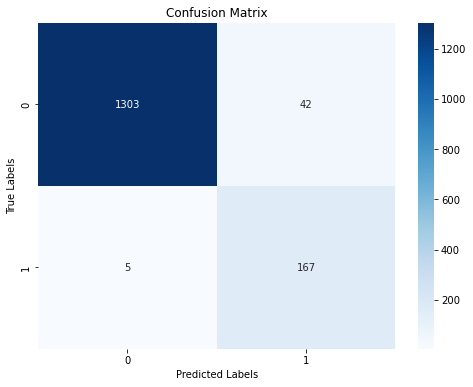

In [159]:
def adjust_predictions(row):
    if (row['DEFAULT_STATUS_ENCODED'] == 1 and row['Probabilities'] <= 0.5 and
        row['avg_eod_bal_3_weeks'] < 1500 and
        row['avg_credit_to_debit_amt_ratio_3_weeks'] == 0 and
        row['AVG_DEBIT_CREDIT_COUNT_RATIO'] == 0):
        return 1
    elif (row['DEFAULT_STATUS_ENCODED'] == 0 and row['Probabilities'] > 0.5 and
          row['schm_code_encoded'] in [4, 3] and 
          row['avg_credit_to_debit_amt_ratio_3_weeks'] < 1):
        return 0
    elif (row['DEFAULT_STATUS_ENCODED'] == 0 and row['Probabilities'] > 0.5 and
          row['avg_credit_to_debit_amt_ratio_3_weeks'] == 0  and 
          row['avg_eod_bal_3_weeks'] == 0 ):
        return 0
    else:
        return row['Predictions']

hypthesisdf['adjusted_prediction'] = hypthesisdf.apply(adjust_predictions, axis=1)
hypthesisdf['adjusted_prediction'] = hypthesisdf['adjusted_prediction'].astype(int)
hypthesisdf.fillna(0, inplace=True)
hypthesisdf['Predictions'] = hypthesisdf['adjusted_prediction']
hypthesisdf['Predictions'] = hypthesisdf['Predictions'].astype(int)
cm = confusion_matrix(hypthesisdf['DEFAULT_STATUS_ENCODED'], hypthesisdf['Predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [161]:
from sklearn.metrics import classification_report
report = classification_report(hypthesisdf['DEFAULT_STATUS_ENCODED'], hypthesisdf['Predictions'])

print(report)


              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1345
           1       0.80      0.97      0.88       172

    accuracy                           0.97      1517
   macro avg       0.90      0.97      0.93      1517
weighted avg       0.97      0.97      0.97      1517



In [162]:
import oracledb as orc

########################################################################
##########     CREATE CLASS FOR INSERTING INTO DB.   ###################
########################################################################
class DataMigration:
    def __init__(self):
        pass
    
    def writePandas(self,table_name,
                 columns,sourcedataframe,batch_size = 10000,
                 renamed_columns={}):
        currrow=None
        try:
            # c = props.ProcessDataDbToFile()
            # conn = c.get_db_conn()
            pddata=sourcedataframe
            pddata.rename(columns=renamed_columns, inplace=True)
            print(pddata.shape)
            print(pddata.head(3))
            
            connection = orc.connect(user='analytics', password='icub3pr0d2018#', dsn='192.168.202.75:1521/icubeprd')
            with connection.cursor() as cur:
                i=0
                colnanmesstr="("
                placeholder="("
                for col in columns:
                    if i==0:
                        placeholder=placeholder+":v"+str(i)
                        colnanmesstr = colnanmesstr + col
                    else:
                        placeholder = placeholder + ",:v" + str(i)
                        colnanmesstr = colnanmesstr + "," + col
                    i=i+1
                placeholder = placeholder + ")"
                colnanmesstr=colnanmesstr+")"
                sql = f"""insert into {table_name} {colnanmesstr} values {placeholder}"""
                insertdata = []
                try:

                    # Predefine the memory areas to match the table definition
                    cur.setinputsizes(None, 25)
                    # Adjust the batch size to meet your memory and performance requirements
                    # batch_size = 10000
                    for record in pddata.itertuples(index=False):
                        row=record._asdict()
                        record_insert = tuple(row[col] for col in columns)
                        # print(record_insert)
                        insertdata.append(record_insert)
                        if len(insertdata) % batch_size == 0:
                            # print(insertdata)
                            cur.executemany(sql, insertdata)
                            insertdata = []
                            connection.commit()
                        # print(row)
                    if insertdata:
                        cur.executemany(sql, insertdata)
                    connection.commit()
                    # conn.close()
                    print("end---",pddata.shape)
                except Exception as e:
                    print(e)
                    print(insertdata)
                    raise e
        except Exception as e:
            print("overall",e)
            # conn.rollback()
            raise e


In [163]:
from datetime import datetime
batch_no = datetime.today().strftime('%Y%m')

batch_no = int(batch_no) - 1

hypthesisdf["BATCH_NO"] = batch_no

In [166]:
hypthesisdf.columns

Index(['CIF_ID', 'REP_PERD_MTHS', 'DIS_AMT',
       'avg_credit_to_debit_amt_ratio_3_weeks', 'schm_code_encoded',
       'avg_eod_bal_3_weeks', 'AVG_DEBIT_CREDIT_COUNT_RATIO', 'FLOW_AMT',
       'CUST_AGE', 'no_of_loan_accounts', 'DEFAULT_STATUS_ENCODED',
       'Predictions', 'Probabilities', 'adjusted_prediction', 'BATCH_NO'],
      dtype='object')

In [168]:
hypthesisdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1517 entries, 0 to 1516
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CIF_ID                                 1517 non-null   object 
 1   REP_PERD_MTHS                          1517 non-null   int64  
 2   DIS_AMT                                1517 non-null   float64
 3   avg_credit_to_debit_amt_ratio_3_weeks  1517 non-null   float64
 4   schm_code_encoded                      1517 non-null   int64  
 5   avg_eod_bal_3_weeks                    1517 non-null   float64
 6   AVG_DEBIT_CREDIT_COUNT_RATIO           1517 non-null   float64
 7   FLOW_AMT                               1517 non-null   float64
 8   CUST_AGE                               1517 non-null   int64  
 9   no_of_loan_accounts                    1517 non-null   int64  
 10  DEFAULT_STATUS_ENCODED                 1517 non-null   int64  
 11  Pred

In [169]:
cols = ['CIF_ID', 'REP_PERD_MTHS', 'DIS_AMT',
       'avg_credit_to_debit_amt_ratio_3_weeks', 'schm_code_encoded',
       'avg_eod_bal_3_weeks', 'AVG_DEBIT_CREDIT_COUNT_RATIO', 'FLOW_AMT',
       'CUST_AGE', 'no_of_loan_accounts', 'DEFAULT_STATUS_ENCODED',
       'Predictions', 'Probabilities', 'adjusted_prediction', 'BATCH_NO']

In [170]:
########################################################################
##########     USING THE CLASS TO INSERT.   ############################
########################################################################
writer = DataMigration()
writer.writePandas(table_name="EWS_LOANS_SCORE",columns=cols,
                   sourcedataframe=hypthesisdf)

(1517, 15)
    CIF_ID  REP_PERD_MTHS     DIS_AMT  avg_credit_to_debit_amt_ratio_3_weeks  \
0  0001596             24   3000000.0                                    8.1   
1  0001726            180 100000000.0                                    0.0   
2  0008874             12   7000000.0                                    2.8   

   schm_code_encoded  avg_eod_bal_3_weeks  AVG_DEBIT_CREDIT_COUNT_RATIO  \
0                  1             189102.5                           2.0   
1                  4                  0.0                           0.0   
2                  1               2752.1                           3.0   

   FLOW_AMT  CUST_AGE  no_of_loan_accounts  DEFAULT_STATUS_ENCODED  \
0  146882.0        68                    4                       0   
1 1408845.0        49                    1                       0   
2 1410094.0        66                    1                       0   

   Predictions  Probabilities  adjusted_prediction  BATCH_NO  
0            0         